# key words
- datasets: UCI pima-indians-diabetes
- preprocessing: binarize
- model selection: train_test_split
- regressor: LogisticRegression
- metrics: accuracy_score, confusion_matrix, roc_curve

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import binarize

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve

data_address = os.path.join(os.getcwd(), "pima-indians-diabetes.csv")
column_names = ['pregnancy_x', # number of times pregnant
                'plasma_con', # plasma glucose concentration a 2 hours in an oral glucose tolerance test
                'blood_pressure', # diastolic blood pressure (mm Hg)
                'skin_mm', # triceps skin fold thickness (mm)
                'insulin', # 2-hour serum insulin (mu U/ml)
                'bmi', # body mass index (weight in kg/(height in m)^2)
                'pedigree_func', # diabetes pedigree function
                'age', # age (years)
                'target'] # class varible (0 or 1)
feature_names = column_names[:-1]
target_name = column_names[-1]

# load sample data
data = pd.read_csv(data_address , names=column_names, skiprows=1)

# list first 5 rows of the data
data.head()

,pregnancy_x,plasma_con,blood_pressure,skin_mm,insulin,bmi,pedigree_func,age,target
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [2]:
# overview distribution of the data
data.describe()

,pregnancy_x,plasma_con,blood_pressure,skin_mm,insulin,bmi,pedigree_func,age,target
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000AB2E438>,
      dtype=object)

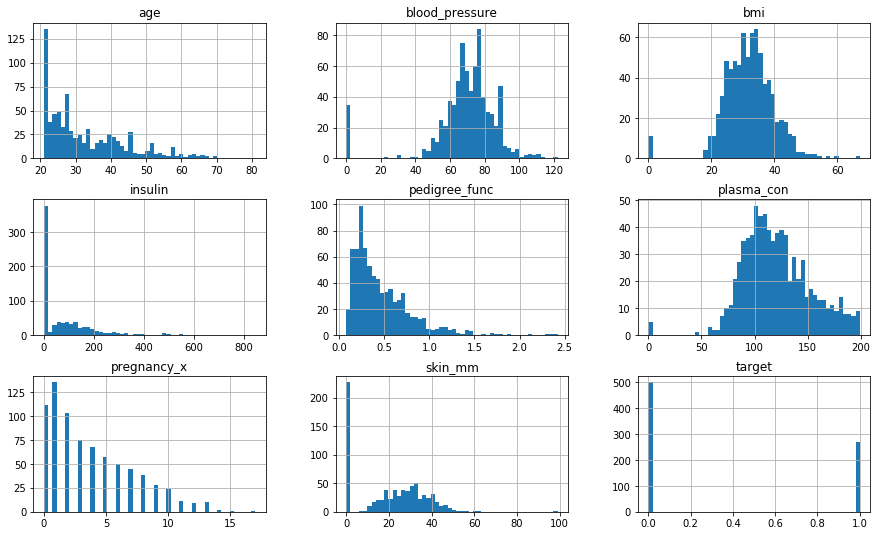

In [3]:
# data distribution of all features
data.hist(figsize=(15, 9), bins=50)
# data[data.columns[:-1]].hist(figsize=(15, 9), bins=50)

# data distribution of certain feature
# data.pregnancy_x.hist(bins=50)

In [4]:
# y_label distribution
data.target.value_counts()

0    500
1    268
Name: target, dtype: int64

In [5]:
# logistic regression
X = data[feature_names]
y = data[target_name]

# stratify=y makes the distribution of splitted dataset the same as y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7, stratify=y)

log_reg = LogisticRegression(solver='lbfgs')
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

# accuracy
accuracy_score(y_test, y_pred)

d:\Miniconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


0.7857142857142857

In [6]:
# confusion matrix
#                   |   Prediction (P/N)
#                   | Predict: 1 | Predict: 0
# --------------------------------------------
# Truth | Actual: 1 |     TP  33 |     FN  21
# (T/F) | Actual: 0 |     FP  12 |     TN  88
confusion_matrix(y_test, y_pred, labels=[1, 0])

array([[33, 21],
       [12, 88]], dtype=int64)

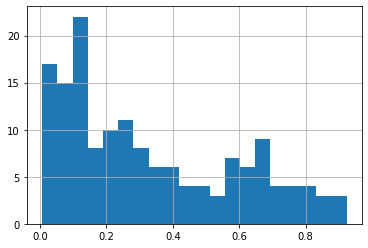

In [7]:
# probabilities of prediction
y_pred_proba = log_reg.predict_proba(X_test)
pd.Series(y_pred_proba[:, 1]).hist(bins=20)

In [8]:
# binarize probabilies with threshold 0.5
y_pred_default = binarize(y_pred_proba, threshold=0.5)
confusion_matrix(y_test, y_pred_default[:, 1], labels=[1, 0])

array([[33, 21],
       [12, 88]], dtype=int64)

In [9]:
# binarize probabilies with low threshold 0.2
y_pred_low = binarize(y_pred_proba, threshold=0.2)
confusion_matrix(y_test, y_pred_low[:, 1], labels=[1, 0])

array([[47,  7],
       [42, 58]], dtype=int64)

d:\Miniconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in longlong_scalars
  import sys


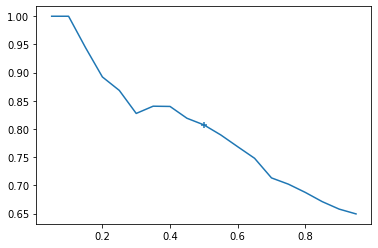

In [10]:
# NPV (negative predictive value) = FN / Negatives = FN / (TN + FN)
def npv_func(y, y_pred_proba, threshold, y_label=[1, 0]):
    y_pred_threhold = binarize(y_pred_proba, threshold=threshold)
    matrix = confusion_matrix(y, y_pred_threhold[:, 1], labels=y_label)
    FN = matrix[1][1]
    TN = matrix[0][1]
    npv = FN / (FN + TN)
    return npv

# plot NPV with various probabilies
thresholds = np.arange(0., 1., 0.05)
npvs = []
for threshold in thresholds:
    npvs.append(npv_func(y_test, y_pred_proba, threshold))
plt.plot(thresholds, npvs)
th = 0.5
plt.scatter([th], [npvs[np.where(thresholds==th)[0][0]]], marker='+')

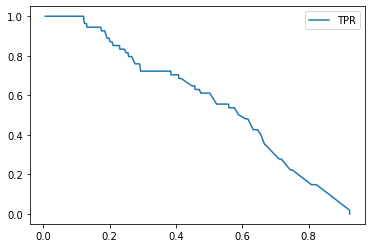

In [16]:
# ROC analysis
#                   |   Prediction (P/N)
#                   | Predict: 1 | Predict: 0
# --------------------------------------------
# Truth | Actual: 1 |         TP |         FN
# (T/F) | Actual: 0 |         FP |         TN

# sensitivity = TPR (true positive rate) = TP / Ground Truth = TP / (TP + FN)
# FPR (false positive rate) = FP / Ground Truth = FP / (FP + TN)

# precision = TP / (TP + FP)
# recall = TPR = TP / (TP + FN)
fpr, tpr, ths = roc_curve(y_test, y_pred_proba[:, 1])
ths[0] -= np.max(y_test)
plt.plot(ths, tpr, label="TPR")
plt.legend()